# RL Algorithms - DUE, ADP and Temporal Difference Learning

In [171]:
#Importing Libraries
import random
import matplotlib.pyplot as plt
import time

## Defining a custom Grid world

In [172]:
'''
Grid World

Default Grid world - 3x4 Grid world with obstacles, goals and blocked states as below:
         _________________
        |   |    |    |   |
(2,0)   |___|____|____|+1_|
         _________________
        |   |XXXX|    |   |
(1,0)   |___|XXXX|____|-1_|
         _________________
        |   |    |    |   |
(0,0)   |___|____|____|___|

        (0,0)          (0,3)
        
Options -
rows -> Number of rows in the grid
cols -> Number of columns in the grid
goal -> List of tuples containing coordinates of goals
blocked -> List of tuples containing coordinates of blocked states
Obstacles -> List of tuples containing coordinates of Obstacles i.e prohibited cells
randomness -> Probability with which any random action will be selected instead of the original action

Possible Actions -
0 -> UP
1 -> DOWN
2 -> LEFT
3 -> RIGHT

Reward -
+1 -> Goal cells
-1 -> Blocked cells
-0.04 -> For all other cells
'''
class Grid:
    def __init__(self,rows=3,cols=4,goal=[(2,3)],blocked=[(1,3)],obstacles=[(1,1)],randomness=0.2):
        self.grid = [[ -0.04 for i in range(cols)] for j in range(rows)]
        self.goal=goal
        self.blocked=blocked
        self.obstacles=obstacles
        self.rows = rows
        self.cols = cols
        if randomness>1:
            raise ValueError('Value should be between 0 and 1')
        else:
            self.randomness = randomness
        for g in goal:
            self.grid[g[0]][g[1]]=1
        for b in blocked:
            self.grid[b[0]][b[1]]=-1
        for o in obstacles:
            self.grid[o[0]][o[1]]=0

    def get_rew(self,a,b):        #Given any state returns the reward
        
        return self.grid[a][b]
        
    def is_terminal(self,a,b):    #Returns true if a state is a terminal state otherwise false
        
        if (a,b) in self.goal or (a,b) in self.blocked:
            return True
        else:
            return False
        
    def get_nextState(self,action,a,b): #Given action and current state returns the next state
        
        num = random.uniform(0,1)
        if num<self.randomness:         #Any random action is selected with a probability equal to randomness
            action = random.randint(0,3)
        x=a
        y=b
        if action == 0:
            x=a+1
            y=b
            if (x,y) in self.obstacles:
                x=a
            if x >= self.rows:
                x=a
        elif action == 1:
            x=a-1
            y=b
            if (x,y) in self.obstacles:
                x=a
            if x<0:
                x=a
        elif action == 2:
            x=a
            y=b-1
            
            if (x,y) in self.obstacles:
                y=b
            if y<0:
                y=b
        elif action == 3:
            x=a
            y=b+1
            
            if (x,y) in self.obstacles:
                y=b
            if y>=self.cols:
                y=b
        else:
            raise ValueError('Invalid Action, value should be betweem 0 and 3')
        
        return (x,y)

Create an instance of the grid world.

Without any options the default 3x4 grid world is created.

For a grid world without any obstacles use:
grid = Grid(obstacles = [ ])

In [173]:
grid = Grid()

Define the policy that you want to evaluate.
Try different policies.

In [174]:
policy ={ (0,0):0, (0,1):2, (0,2):2,(0,3):2,
         (1,0):0,(1,1):None,(1,2):0,(1,3):None,
         (2,0):3,(2,1):3,(2,2):3,(2,3):None}

## Direct Utility Estimate

In [175]:
sx=0
sy=0
U=[[0 for i in range(4)] for j in range(3)]
freq=[[0 for i in range(4)] for j in range(3)]

In [176]:
start= time.time()
lis1=[]
lis2=[]
lis3=[]
for trials in range(500):
    lis1.append(U[1][0])
    lis2.append(U[2][0])
    lis3.append(U[2][2])
    sx=0
    sy=0
    U_run =[[0 for i in range(4)] for j in range(3)]
    freq_run =[[0 for i in range(4)] for j in range(3)]
    rew = []
    state = []
    while True: 
        rew.append(grid.get_rew(sx,sy))
        state.append([sx,sy])
        if grid.is_terminal(sx,sy):
            break
        action = policy[(sx,sy)]
        sx,sy = grid.get_nextState(action,sx,sy)
    
    Sum = 0
    for i in range(len(state)-1,0,-1):
        Sum += rew[i]
        U_run[state[i][0]][state[i][1]]+=Sum
        freq_run[state[i][0]][state[i][1]]+=1
    for i in range(len(state)-1,0,-1):
        U[state[i][0]][state[i][1]] = (U_run[state[i][0]][state[i][1]]+U[state[i][0]][state[i][1]]*freq[state[i][0]][state[i][1]])/(freq[state[i][0]][state[i][1]]+freq_run[state[i][0]][state[i][1]])
        freq[state[i][0]][state[i][1]]+=freq_run[state[i][0]][state[i][1]]

end = time.time()
print('Time taken',end-start)

Time taken 0.028000354766845703


Utility values for all the states

In [177]:

for i in range(grid.rows):
    for j in range(grid.cols):
        print((i,j),U[i][j])


(0, 0) 0.7266403162055335
(0, 1) 0.7128888888888884
(0, 2) 0.6719999999999997
(0, 3) 0
(1, 0) 0.763197093551317
(1, 1) 0
(1, 2) 0.6669565217391304
(1, 3) -1.0
(2, 0) 0.8267526881720423
(2, 1) 0.8726315789473622
(2, 2) 0.9175925925925964
(2, 3) 1.0


PLotting Utility values for states (1,0),(2,0) and (2,2)

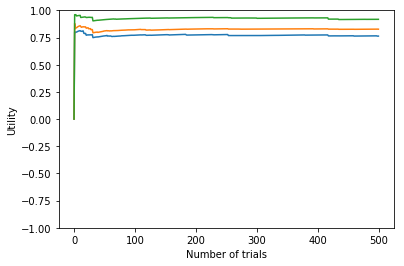

In [178]:
plt.plot(lis1)
plt.plot(lis2)
plt.plot(lis3)
plt.ylabel('Utility')
plt.xlabel('Number of trials')
axes = plt.gca()
axes.set_ylim([-1,1])
plt.show()

## Adaptive Dynamic Programming

In [179]:
#Initializing table of utilities and frequency
U=[[0 for i in range(4)] for j in range(3)]
freq=[[0 for i in range(4)] for j in range(3)]

#Gamma value set to 1
gamma = 1
visited=[]

def alpha(n):
    return 60/(59+n)


In [180]:
start = time.time()
lis1=[]
lis2=[]
lis3=[]
for trials in range(500):
    lis1.append(U[1][0])
    lis2.append(U[2][0])
    lis3.append(U[2][2])
    r=-0.04
    prev_sx = None
    prev_sy = None
    prev_a = None
    prev_r = None
    sx=0
    sy=0

    while True:
        r = grid.get_rew(sx,sy)
        if (sx,sy) not in visited:
            U[sx][sy] = r
            visited.append((sx,sy))
        if prev_sx != None and prev_sy != None:
            freq[prev_sx][prev_sy]+=1
            U[prev_sx][prev_sy] = U[prev_sx][prev_sy] + alpha(freq[prev_sx][prev_sy] )*(grid.get_rew(prev_sx,prev_sy) + gamma*U[sx][sy] - U[prev_sx][prev_sy])
        if grid.is_terminal(sx,sy):
            prev_sx = None
            prev_sy = None
            prev_a = None
            prev_r = None
            break
        else:
            prev_sx = sx
            prev_sy = sy
            prev_a = policy[(sx,sy)]
            prev_r = r
        sx,sy=grid.get_nextState(prev_a,sx,sy)
end = time.time()
print('Time taken', end-start)

Time taken 0.021261930465698242


Utility values for all the states

In [181]:
for i in range(grid.rows):
    for j in range(grid.cols):
        print((i,j),U[i][j])


(0, 0) 0.7534008497815629
(0, 1) 0.6825110874749132
(0, 2) 0.5809024033430614
(0, 3) 0
(1, 0) 0.793689966904409
(1, 1) 0
(1, 2) 0.8934101204687205
(1, 3) -1
(2, 0) 0.8439077244906965
(2, 1) 0.8931169260223154
(2, 2) 0.9564572541235846
(2, 3) 1


PLotting utilities for states (1,0) , (2,0) and (2,2)

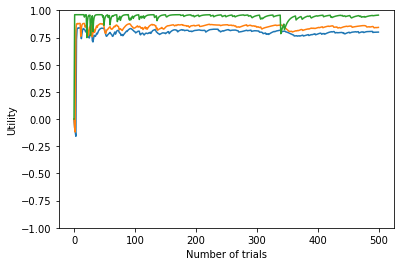

In [182]:
plt.plot(lis1)
plt.plot(lis2)
plt.plot(lis3)
plt.ylabel('Utility')
plt.xlabel('Number of trials')
axes = plt.gca()
axes.set_ylim([-1,1])
plt.show()

## Temporal-difference learning

In [183]:
#Initializing table of utilities and rewards
U=[[0 for i in range(4)] for j in range(3)]
R=[[0 for i in range(4)] for j in range(3)]
Nsa ={}
Ns_sa = {}
P = {}

In [184]:
start = time.time()
lis1=[]
lis2=[]
lis3=[]
for trains in range(500):
    lis1.append(U[1][0])
    lis2.append(U[2][0])
    lis3.append(U[2][2])
    sx=0
    sy=0
    prev_sx=None
    prev_sy=None
    prev_a=None
    visited=[]
    while True:
        r = grid.get_rew(sx,sy)
        if (sx,sy) not in visited:
            U[sx][sy] = r
            R[sx][sy] = r
        
        if prev_sx != None and prev_sy != None:
            if ((prev_sx,prev_sy),prev_a) not in Nsa:
                Nsa[((prev_sx,prev_sy),prev_a)]=1
            else:
                Nsa[((prev_sx,prev_sy),prev_a)]+=1
                
            if ((sx,sy),(prev_sx,prev_sy),prev_a) not in Ns_sa:
                Ns_sa[((sx,sy),(prev_sx,prev_sy),prev_a)]=1
            else:
                Ns_sa[((sx,sy),(prev_sx,prev_sy),prev_a)]+=1
            
        for key in Ns_sa:  
            P[key] = Ns_sa[key]/Nsa[(key[1],key[2])]
        
        sum_s={}
        for key in Ns_sa:
            if key[1] not in sum_s:
                sum_s[key[1]]=P[key]*U[key[0][0]][key[0][1]]
            else:
                sum_s[key[1]]+=P[key]*U[key[0][0]][key[0][1]]
                
        for s in Nsa:
            U[s[0][0]][s[0][1]] =R[s[0][0]][s[0][1]] + gamma*sum_s[s[0]]
        
        
        if grid.is_terminal(sx,sy):
            prev_sx=None
            prev_sy=None
            prev_a = None
            break
        else:
            prev_sx=sx
            prev_sy=sy
            prev_a = policy[(sx,sy)]
        
        sx,sy = grid.get_nextState(prev_a,sx,sy)

end = time.time()
print('Time taken', end - start)

Time taken 0.1111912727355957


In [185]:
for i in range(grid.rows):
    for j in range(grid.cols):
        print((i,j),U[i][j])


(0, 0) 0.00899295294844614
(0, 1) 0.3147565238648936
(0, 2) -0.13866843305764456
(0, 3) 0.009405390799913302
(1, 0) 0.5316571108300682
(1, 1) 0
(1, 2) 0.6688976346672012
(1, 3) -1
(2, 0) 0.02622915165576773
(2, 1) 0.7395958919264567
(2, 2) 0.866899994199754
(2, 3) 1


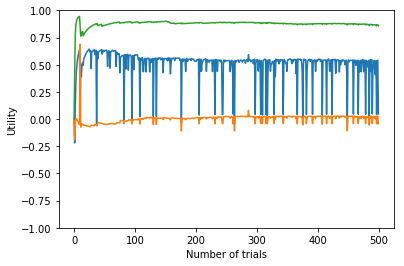

In [186]:
plt.plot(lis1)
plt.plot(lis2)
plt.plot(lis3)
plt.ylabel('Utility')
plt.xlabel('Number of trials')
axes = plt.gca()
axes.set_ylim([-1,1])
plt.show()

1. We observe that Adaptive Dynamic Programming method converges the fastest though it takes the longest computation time for 500 trials compared to other two methods. 

2. The Direct Utility estimate method converges slowly.

3. The Temporal-Difference method takes much less time compared to ADP method per observation.

4. ADP method becomes intractable as size of the environment increases as we need to keep a track of all possible transitions.
